In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sqlcontext = SQLContext(sc)

In [44]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import udf
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import numpy as np

In [4]:
review_data = sqlcontext.read.json('./data/reviews_Cell_Phones_and_Accessories.json')
review_data.show(5)

+----------+-------+-------+--------------------+-----------+--------------+----------------+---------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|    reviewerName|        summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+----------------+---------------+--------------+
|011040047X| [2, 2]|    1.0|The case pictured...|08 14, 2012|A1EWN6KZ4HMLT7|     S. Prescott|    Wrong color|    1344902400|
|0110400550| [0, 0]|    5.0|Saw this same cas...|11 22, 2012| A1YX2RBMS1L9L|    Andrea Busch|  Great product|    1353542400|
|0110400550| [3, 3]|    5.0|case fits perfect...|07 18, 2013|A180NNPPKWCCU0|Aniya pennington|        Perfect|    1374105600|
|0110400550| [4, 4]|    5.0|Best phone case e...|01 13, 2013| A3HVRXV0LVJN7|    BiancaNicole|          A++++|    1358035200|
|0110400550| [0, 1]|    1.0|It may look cute....|11 26, 2012|A292527VPX98P8|          Cebell|Do NOT GET IT!!|    1353888000|


In [5]:
meta_data = sqlcontext.read.json('./data/meta_Cell_Phones_and_Accessories.json')
meta_data.show(5)

+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|_corrupt_record|      asin|brand|          categories|         description|               imUrl|price|             related|           salesRank|               title|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|           null|0110400550|     |[[Cell Phones & A...|Pink & White 3D M...|http://ecx.images...| 3.33|[[B00C56IXFG, B00...|[,,,,,, 83460,,,,...|Pink &amp; White ...|
|           null|011040047X| null|[[Cell Phones & A...|Purple Hard Case ...|http://ecx.images...| 1.94|[,,, [B008RU7UL2,...|[,,,,,, 495795,,,...|Purple Hard Case ...|
|           null|0195866479| null|[[Cell Phones & A...|Thin and light we...|http://ecx.images...| 2.94|[,,, [B00530RXP2,...|[,,,,,, 371302,,,...|Hello Kitty Light...

In [6]:
review_data.registerTempTable("review_data")

In [7]:
meta_data.registerTempTable("meta_data")

## 1. Ratings and Products

In [8]:
rating = sqlcontext.sql("SELECT asin, overall FROM review_data")
rating.show(5)

+----------+-------+
|      asin|overall|
+----------+-------+
|011040047X|    1.0|
|0110400550|    5.0|
|0110400550|    5.0|
|0110400550|    5.0|
|0110400550|    1.0|
+----------+-------+
only showing top 5 rows



### 1.1. Average Rating per Product

In [9]:
avg_rating_per_product = rating.groupBy('asin').agg(F.mean('overall'))
avg_rating_per_product.show(5)

+----------+------------+
|      asin|avg(overall)|
+----------+------------+
|6175001532|        2.88|
|9572548964|         2.0|
|9861033181|         5.0|
|9967354976|         5.0|
|9983781239|         5.0|
+----------+------------+
only showing top 5 rows



### 1.2. Number/Percentage of products per rating

In [10]:
# Number of products per rating
total_per_rating = rating.groupBy('overall').count()
total_per_rating.show()

+-------+-------+
|overall|  count|
+-------+-------+
|    1.0| 498617|
|    4.0| 632300|
|    3.0| 351322|
|    2.0| 256144|
|    5.0|1708866|
+-------+-------+



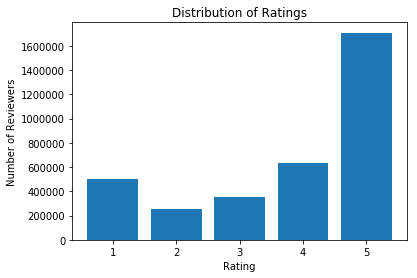

In [11]:
x = total_per_rating.select("overall").rdd.flatMap(lambda x: x).collect()
y = total_per_rating.select("count").rdd.flatMap(lambda x: x).collect()

plt.bar(x,y)
plt.xlabel("Rating")
plt.ylabel("Number of Reviewers")
plt.title("Distribution of Ratings")
plt.savefig("./figures/overall_ratings_distribution.png")

In [12]:
# Percentage of products per rating
df = total_per_rating.withColumn('percent', F.col('count')/F.sum('count').over(Window.partitionBy()))
df.show()

+-------+-------+-------------------+
|overall|  count|            percent|
+-------+-------+-------------------+
|    1.0| 498617|0.14464200294205612|
|    4.0| 632300|0.18342162112455468|
|    3.0| 351322|0.10191372888932596|
|    2.0| 256144|0.07430388695449618|
|    5.0|1708866|0.49571876008956706|
+-------+-------+-------------------+



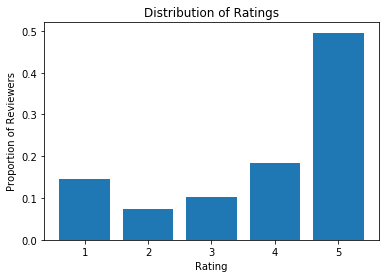

In [13]:
x1 = df.select("overall").rdd.flatMap(lambda x: x).collect()
y1 = df.select("percent").rdd.flatMap(lambda x: x).collect()

plt.bar(x1,y1)
plt.xlabel("Rating")
plt.ylabel("Proportion of Reviewers")
plt.title("Distribution of Ratings")
plt.savefig("./figures/overall_ratings_percent_distribution.png")

### 1.3. Product images in each rating category

In [14]:
image_rating = review_data.join(meta_data, review_data.asin == meta_data.asin)
image_rating = image_rating[['overall', 'imUrl']]
image_rating.show(5)

+-------+--------------------+
|overall|               imUrl|
+-------+--------------------+
|    5.0|http://ecx.images...|
|    3.0|http://ecx.images...|
|    1.0|http://ecx.images...|
|    1.0|http://ecx.images...|
|    1.0|http://ecx.images...|
+-------+--------------------+
only showing top 5 rows



In [15]:
window = Window.partitionBy(rating['overall']).orderBy(rating['asin'].desc())
top_5_per_rating = rating.select('*', F.rank().over(window).alias('rank')).filter(F.col('rank') <= 5)
top_5_per_rating.show(5)

+----------+-------+----+
|      asin|overall|rank|
+----------+-------+----+
|B00LN8BOYE|    1.0|   1|
|B00LMJJOD2|    1.0|   2|
|B00LKINXUA|    1.0|   3|
|B00LGM1OHY|    1.0|   4|
|B00LGIEO34|    1.0|   5|
+----------+-------+----+
only showing top 5 rows



In [16]:
top_5_per_rating.registerTempTable("top_5_per_rating")
df = sqlcontext.sql("SELECT asin, imUrl FROM meta_data WHERE asin IN (SELECT asin FROM top_5_per_rating)")
df.show(5)

+----------+--------------------+
|      asin|               imUrl|
+----------+--------------------+
|B00LGM1OHY|http://ecx.images...|
|B00LORXVUE|                null|
|B00LFD9DUE|http://ecx.images...|
|B00LMJJOD2|http://ecx.images...|
|B00LGIEO34|http://ecx.images...|
+----------+--------------------+
only showing top 5 rows



In [17]:
df.registerTempTable("df")

In [18]:
images = sqlcontext.sql("SELECT * FROM top_5_per_rating LEFT JOIN df ON top_5_per_rating.asin = df.asin")
images.show(5)

+----------+-------+----+----------+--------------------+
|      asin|overall|rank|      asin|               imUrl|
+----------+-------+----+----------+--------------------+
|B00LGM1OHY|    1.0|   4|B00LGM1OHY|http://ecx.images...|
|B00LORXVUE|    4.0|   3|B00LORXVUE|                null|
|B00LFD9DUE|    2.0|   4|B00LFD9DUE|http://ecx.images...|
|B00LMJJOD2|    1.0|   2|B00LMJJOD2|http://ecx.images...|
|B00LMJJOD2|    4.0|   5|B00LMJJOD2|http://ecx.images...|
+----------+-------+----+----------+--------------------+
only showing top 5 rows



In [19]:
images_pd = images.toPandas()

url1 = images_pd['imUrl'][0] # Rating 1-star
url2 = images_pd['imUrl'][3] # Rating 1-star
url3 = images_pd['imUrl'][2] # Rating 2-star
url4 = images_pd['imUrl'][7] # Rating 2-star
url5 = images_pd['imUrl'][10] # Rating 3-star
url6 = images_pd['imUrl'][16] # Rating 3-star
url7 = images_pd['imUrl'][14] # Rating 4-star
url8 = images_pd['imUrl'][9] # Rating 4-star
url9 = images_pd['imUrl'][11] # Rating 5-star
url10 = images_pd['imUrl'][22] # Rating 5-star

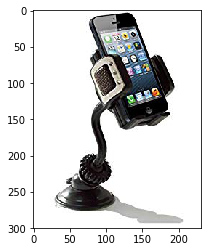

In [20]:
response = requests.get(url1)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.savefig("./figures/one_star_first_product.png")

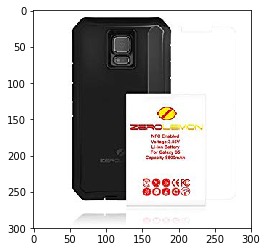

In [21]:
response = requests.get(url2)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.savefig("./figures/one_star_second_product.png")

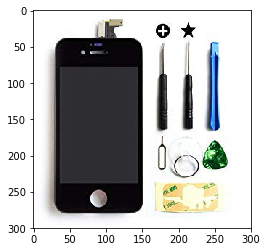

In [22]:
response = requests.get(url3)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.savefig("./figures/two_star_first_product.png")

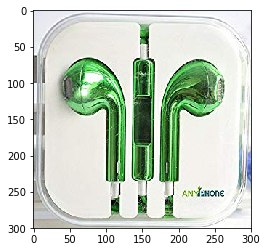

In [23]:
response = requests.get(url4)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.savefig("./figures/two_star_second_product.png")

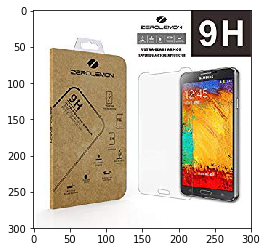

In [24]:
response = requests.get(url5)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.savefig("./figures/three_star_first_product.png")

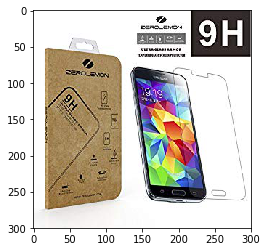

In [25]:
response = requests.get(url6)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.savefig("./figures/three_star_second_product.png")

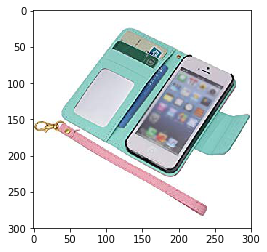

In [26]:
response = requests.get(url7)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.savefig("./figures/four_star_first_product.png")

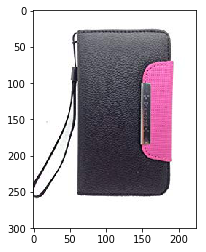

In [27]:
response = requests.get(url8)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.savefig("./figures/four_star_second_product.png")

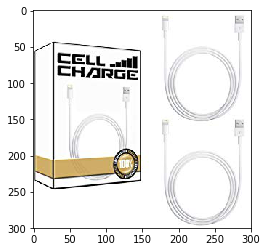

In [28]:
response = requests.get(url9)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.savefig("./figures/five_star_first_product.png")

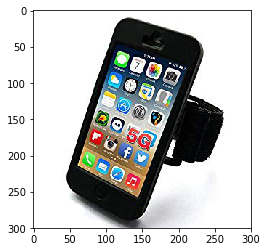

In [29]:
response = requests.get(url10)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.savefig("./figures/five_star_second_product.png")

## 2. Reviews and Products

### 2.1. Most frequently reviewed products

In [30]:
most_reviewed_products = rating.groupBy('asin').count().sort('count', ascending = False)
most_reviewed_products.registerTempTable("most_reviewed_products")
top_products = sqlcontext.sql("SELECT asin, count FROM most_reviewed_products WHERE count > 4000")

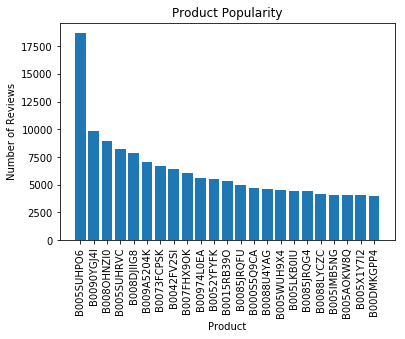

In [31]:
x2 = top_products.select("asin").rdd.flatMap(lambda x: x).collect()
y2 = top_products.select("count").rdd.flatMap(lambda x: x).collect()

plt.bar(range(len(x2)),y2, tick_label=x2)
plt.xlabel("Product")
plt.xticks(rotation=90)
plt.ylabel("Number of Reviews")
plt.title("Product Popularity")
plt.savefig("./figures/most_frequent_reviews.png")

### 2.2. Average length of reviews per product

In [32]:
reviews = sqlcontext.sql("SELECT asin, reviewText, helpful FROM review_data")

def clean_text(review):
    
    # Removes non-english words (punctuations and numbers)
    import re
    cleaned_text = re.sub("[^a-zA-Z\']", " ", str(review))
    
    # Covert everything to lower case
    cleaned_text = cleaned_text.lower()
    
    # Remove the word 'quot'
    cleaned_text = cleaned_text.replace("quot", "")
    
    # Remove any extra white space
    cleaned_text = ' '.join(cleaned_text.split())
    
    return(cleaned_text)

clean_text_udf = udf(clean_text)

reviews = reviews.withColumn('reviewText', clean_text_udf('reviewText'))
reviews.show(5)

+----------+--------------------+-------+
|      asin|          reviewText|helpful|
+----------+--------------------+-------+
|011040047X|the case pictured...| [2, 2]|
|0110400550|saw this same cas...| [0, 0]|
|0110400550|case fits perfect...| [3, 3]|
|0110400550|best phone case e...| [4, 4]|
|0110400550|it may look cute ...| [0, 1]|
+----------+--------------------+-------+
only showing top 5 rows



In [33]:
helpful_ratio = reviews.rdd\
    .map(lambda x: (x["asin"], x["helpful"][0],x["helpful"][1]-x["helpful"][0], x["helpful"][1], x["reviewText"],len(x["reviewText"].split())))\
    .toDF(["asin", "Helpful","Not_Helpful", "Total", "reviewText","Length"])
helpful_ratio.show(5)

+----------+-------+-----------+-----+--------------------+------+
|      asin|Helpful|Not_Helpful|Total|          reviewText|Length|
+----------+-------+-----------+-----+--------------------+------+
|011040047X|      2|          0|    2|the case pictured...|    33|
|0110400550|      0|          0|    0|saw this same cas...|    20|
|0110400550|      3|          0|    3|case fits perfect...|    20|
|0110400550|      4|          0|    4|best phone case e...|    22|
|0110400550|      0|          1|    1|it may look cute ...|    42|
+----------+-------+-----------+-----+--------------------+------+
only showing top 5 rows



In [34]:
avg_length_per_product = helpful_ratio.groupBy('asin').agg(F.mean('Length').alias('mean_len'))
avg_length_desc = avg_length_per_product.sort('mean_len', ascending = False)
avg_length_desc.show(5)

+----------+--------+
|      asin|mean_len|
+----------+--------+
|B00120LA4C|  3165.0|
|B00ESFF274|  2393.0|
|B003MVZEYQ|  2104.5|
|B003UHV8HO|  1880.0|
|B001BJF2XE|  1856.0|
+----------+--------+
only showing top 5 rows



In [35]:
avg_length_desc.registerTempTable("avg_length_desc")

less_than_100 = sqlcontext.sql("SELECT * FROM avg_length_desc WHERE mean_len < 100").count()
bet_100_200 = sqlcontext.sql("SELECT * FROM avg_length_desc WHERE mean_len BETWEEN 100 AND 200").count()
bet_200_500 = sqlcontext.sql("SELECT * FROM avg_length_desc WHERE mean_len BETWEEN 201 AND 500").count()
bet_500_1000 = sqlcontext.sql("SELECT * FROM avg_length_desc WHERE mean_len BETWEEN 501 AND 1000").count()
more_than_1000 = sqlcontext.sql("SELECT * FROM avg_length_desc WHERE mean_len > 1000").count()

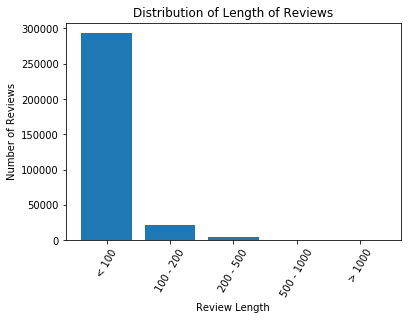

In [36]:
x3 = ['< 100', '100 - 200', '200 - 500', '500 - 1000', '> 1000']
y3 = [less_than_100, bet_100_200, bet_200_500, bet_500_1000, more_than_1000]

plt.bar(range(len(x3)),y3, tick_label=x3)
plt.xlabel("Review Length")
plt.xticks(rotation=60)
plt.ylabel("Number of Reviews")
plt.title("Distribution of Length of Reviews")
plt.savefig("./figures/review_length_distribution.png")

### 2.3. Products with longest reviews

In [37]:
top_len = sqlcontext.sql("SELECT * FROM avg_length_desc WHERE mean_len > 1000")

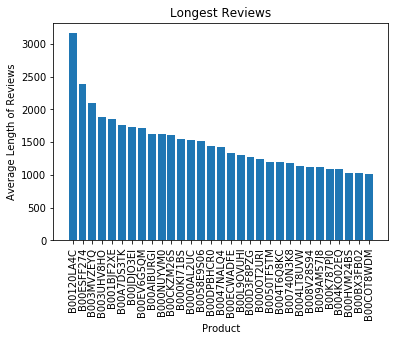

In [38]:
x4 = top_len.select("asin").rdd.flatMap(lambda x: x).collect()
y4 = top_len.select("mean_len").rdd.flatMap(lambda x: x).collect()

plt.bar(range(len(x4)),y4,tick_label=x4)
plt.xlabel("Product")
plt.xticks(rotation=90)
plt.ylabel("Average Length of Reviews")
plt.title("Longest Reviews")
plt.savefig("./figures/products_with_longest_reviews.png")

### 2.4. Distribution of helpfulness of reviews

In [39]:
helpful_ratio.registerTempTable("helpfulratio")

sqlcontext.sql("SELECT Helpful from helpfulratio where Helpful=0").count()
sqlcontext.sql("SELECT Helpful from helpfulratio where Helpful > 4").count()
helpful_ratio.count()

3447249

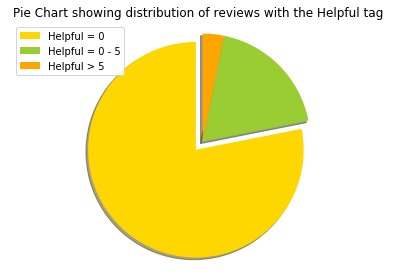

In [40]:
helpful_count = [2662839, 638649, 107626]
labels = 'Helpful = 0', 'Helpful = 0 - 5', 'Helpful > 5'
colors = ['gold', 'yellowgreen', 'orange']
explode = (0.1, 0, 0)  # explode 1st slice

plt.title("Pie Chart showing distribution of reviews with the Helpful tag")
patches, texts = plt.pie(helpful_count, explode=explode, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("./figures/review_helpfulness_distribution.png")

### 2.5. Helpful of reviews v/s Length of reviews

In [41]:
helpful_len = sqlcontext.sql("SELECT Helpful, Length from helpfulratio")

l = helpful_len.select("Helpful").rdd.flatMap(lambda x: x).collect()
l1 = helpful_len.select("Length").rdd.flatMap(lambda x: x).collect()
l3 = { 'Helpful': l, 'Length': l1}

In [42]:
l4 = sqlcontext.sql("SELECT Length from helpfulratio WHERE Helpful = 0")
l4_0 = l4.select("Length").rdd.flatMap(lambda x: x).collect()
l4_1 = sqlcontext.sql("SELECT Length from helpfulratio WHERE Helpful = 1.0")
l4_11 = l4_1.select("Length").rdd.flatMap(lambda x: x).collect()
l4_2 = sqlcontext.sql("SELECT Length from helpfulratio WHERE Helpful = 2.0")
l4_22 = l4_2.select("Length").rdd.flatMap(lambda x: x).collect()
l4_3 = sqlcontext.sql("SELECT Length from helpfulratio WHERE Helpful = 3.0")
l4_33 = l4_3.select("Length").rdd.flatMap(lambda x: x).collect()
l4_4 = sqlcontext.sql("SELECT Length from helpfulratio WHERE Helpful = 4.0")
l4_44 = l4_4.select("Length").rdd.flatMap(lambda x: x).collect()
l4_5 = sqlcontext.sql("SELECT Length from helpfulratio WHERE Helpful = 5.0")
l4_55 = l4_5.select("Length").rdd.flatMap(lambda x: x).collect()
l4_6 = sqlcontext.sql("SELECT Length from helpfulratio WHERE Helpful > 5.0")
l4_66 = l4_6.select("Length").rdd.flatMap(lambda x: x).collect()

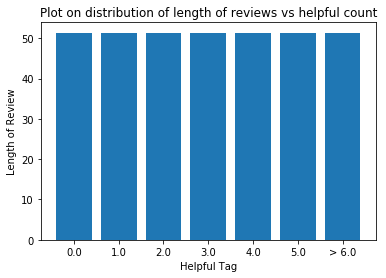

In [45]:
len_count = []
len_count.append(np.mean(l4_0))
helpful_count = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, '> 6.0']

plt.bar(helpful_count, len_count)
plt.xlabel("Helpful Tag")
plt.ylabel("Length of Review")
plt.title("Plot on distribution of length of reviews vs helpful count")
plt.savefig("./figures/length_vs_helpfulness.png")

### 2.6. Ratings and Helpfulness

In [46]:
ratings = sqlcontext.sql("SELECT overall, helpful, reviewText, reviewerID FROM review_data")

In [47]:
ratings_ratio = ratings.rdd\
    .map(lambda x: (x["overall"], x["helpful"][0], x["reviewText"],len(x["reviewText"].split()),x["reviewerID"]))\
    .toDF(["overall","Helpful","reviewText","Length","reviewerID"])

In [48]:
ratings_ratio.registerTempTable("ratingratio")

l5_1 = sqlcontext.sql("SELECT Length from ratingratio WHERE overall = 1.0")
l5_11 = l5_1.select("Length").rdd.flatMap(lambda x: x).collect()
l5_2 = sqlcontext.sql("SELECT Length from ratingratio WHERE overall = 2.0")
l5_22 = l5_2.select("Length").rdd.flatMap(lambda x: x).collect()
l5_3 = sqlcontext.sql("SELECT Length from ratingratio WHERE overall = 3.0")
l5_33 = l5_3.select("Length").rdd.flatMap(lambda x: x).collect()
l5_4 = sqlcontext.sql("SELECT Length from ratingratio WHERE overall = 4.0")
l5_44 = l5_4.select("Length").rdd.flatMap(lambda x: x).collect()
l5_5 = sqlcontext.sql("SELECT Length from ratingratio WHERE overall = 5.0")
l5_55 = l5_5.select("Length").rdd.flatMap(lambda x: x).collect()

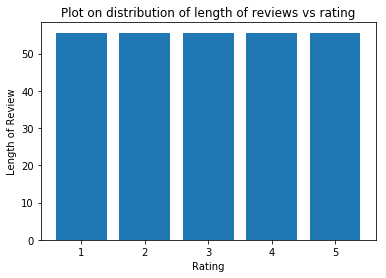

In [49]:
len2_count = []
len2_count.append(np.mean(l5_55))
rating_count = [1.0, 2.0, 3.0, 4.0, 5.0]

plt.bar(rating_count, len2_count)
plt.xlabel("Rating")
plt.ylabel("Length of Review")
plt.title("Plot on distribution of length of reviews vs rating")
plt.savefig("./figures/length_vs_ratings.png")